# Contenido del notebook

> - [Cargar los datos](#datos)
> - [Mi modelo](#my_model)
> - [Entrenar el modelo](#my_model_train)
> - [Mismo modelo, otros datos](#other_data)
> - [Comparación de resultados](#comparacion)
> - [Mi propia transformación](#mytfms)

**Importamos las librerias con las que vamos a trabajar**


In [1]:
import fastai.vision.all as fv
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor()
to_pil = ToPILImage()
import torch 
import torch.nn as nn
from math import prod, sqrt
from pathlib import Path

**Creamos una función para hacer el conteo de parámetros y no pasarnos de 2M**

In [2]:
# Para tener idea de qué tan grande es nuestro modelo
def num_params(model):
    #total=0
    #for p in model.parameters():
        #num=1
        #for s in list(p.size()):
            #num *= s
        #total += num
        
    # Una manera de hacer más optimo lo anterior 
    total = sum([prod(p.shape) for p in model.parameters()])
    return (total)

**Creamos una función para conectar las convoluciones con las líneas densas**

Es decir pasar de la parte convolucional a la parte completamente conectada

In [3]:
# Esta capa servirá para conectar las convolucionales con las lineas densas
class Flatten(nn.Module): #Para hacer un modulo de pytorch, tienes que heredar
    # de nn.Module
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        # return (x.squeeze()) Esto funciona solo si la batchsize es >1
        # si es 1, esto se lo va a quitar
        # solución 
        return (x.view(x.shape[0], -1)) 
        #x.shape[0] es la batchsize
        #-1 si se lo pasas a reshape o a view les dice algo 
        # como tú adivina de que tamaño debe de ser esto

In [4]:
def my_own_splitter(m):
    # la última parte esta en su propio grupo
    # Es decir, la parte linear que se encargara de nuestras salidas
    # estara en su propio grupo
    # Partimos en cinco capas el modelo 
    # siendo la última la capa linear
    return [list(group.parameters()) for group in [m[0:5], m[5:10],m[10:15],m[15:21],m[21:]]]

<a id='datos'><h1><strong>Cargamos los datos</strong></h1></a>


In [5]:
!ls "/storage/recursos"

animals  birds	flowers


In [5]:
birds = Path("/storage/recursos/birds")
animals = Path("/storage/recursos/animals")
flowers = Path("/storage/recursos/flowers")

In [6]:
#files = fv.get_image_files(birds) #Obtenemos los archivos de nuestra carpeta con las subcarpetas train, valid
#files

In [6]:
# Función para cargar los datos
def load_data(folder, img_size, batch_size):
  # Dependiendo de los datos, elegimos las 
  # transformadas que le queremos hacer
  tfms = fv.aug_transforms(flip_vert=True, 
                           max_rotate=360, 
                           max_lighting=0.25,
                           max_zoom=1.2, 
                           max_warp=0.2)
  
  data = fv.DataBlock(blocks = (fv.ImageBlock, fv.CategoryBlock),
                      get_items=fv.get_image_files,
                      get_y=fv.parent_label,
                      splitter=fv.GrandparentSplitter(), 
                      item_tfms=fv.Resize(img_size),
                      batch_tfms=tfms,
                      )
  return data.dataloaders(folder, bs=batch_size)

In [7]:
data_birds = load_data(birds, img_size=224, batch_size=64) # Cargamos los datos
data_animals = load_data(animals, img_size=224, batch_size=64)
data_flowers = load_data(flowers, img_size=224, batch_size=64)

In [8]:
data_birds.c, data_animals.c, data_flowers.c

(200, 30, 102)

<a id="my_model"><h1><strong>1- Crear tu propio modelo</strong></h1></a>

con Conv2d, ReLU, LeakyReLU, Sigmoid, Tanh, BatchNorm2d, Flatten, Linear... Tu modelo deberá usar menos de 2M de parámetros.

In [11]:
# Primer creación: red neuronal convolucional 
my_model = nn.Sequential(
    # Normalizamos los datos
    nn.BatchNorm2d(3),
    # Convolución
    # padding le pone un borde negro a la imagen para no tener perdida de pixeles
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
    # Activación 
    nn.LeakyReLU(),
    nn.BatchNorm2d(32),
    # Maxpool2d toma cada cuadrito de 2x2 y de esos 4 toma 
    # el mayor, reduciendo así todo a la mitad
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2), 
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(512),
    # Aquí es donde pasamos a la parte líneal
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data_birds.c))

In [12]:
num_params(my_model)

1754478

**Creamos el aprendedor y entrenamos el modelo con birds**

In [13]:
learner = fv.Learner(data_birds, my_model, opt_func=fv.ranger, metrics=fv.accuracy).to_fp16()

In [14]:
#learner.summary()

SuggestedLRs(lr_min=0.0033113110810518267, lr_steep=0.019054606556892395)

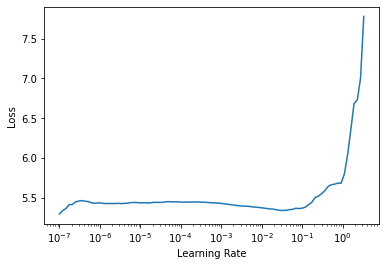

In [14]:
learner.lr_find()

<a id="my_model_train"><h1><strong>2- Entrena tu modelo</strong></h1></a>



> **Entrenamos con nuestro dataset de birds**

In [15]:
learner.fit_one_cycle(31, 1e-4, div=0.9, final_div=10000, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,5.309600,5.215508,0.013980,00:19
1,5.137328,5.090758,0.021401,00:18
2,5.001836,4.999133,0.031584,00:18
3,4.896828,4.929777,0.032620,00:18
4,4.807658,4.850990,0.044356,00:18
5,4.720143,4.785706,0.048671,00:18
6,4.653425,4.741571,0.051433,00:18
7,4.587884,4.683259,0.055402,00:18
8,4.525660,4.632568,0.061615,00:18
9,4.461830,4.577436,0.067138,00:18


<a id="other_data"><h1><strong>3- Descarga otro de los datasets que le tocaron a tus compañeros, o usa el de las flores, (o ambas) para pre-entrenar el mismo modelo (pero desde 0)
</strong></h1></a>


> **Creamos otro aprendedor y entrenamos nuestro modelo (una copia de nuestro modelo original pero sin previo entrenamiento) pero ahora con animals antes de entrenar las últimas capas con nuestro dataset original**

In [20]:
# Primer creación: red neuronal convolucional 
my_aux_model = nn.Sequential(
    # Normalizamos los datos
    nn.BatchNorm2d(3),
    # Convolución
    # padding le pone un borde negro a la imagen para no tener perdida de pixeles
    nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),
    # Activación 
    nn.LeakyReLU(),
    nn.BatchNorm2d(32),
    # Maxpool2d toma cada cuadrito de 2x2 y de esos 4 toma 
    # el mayor, reduciendo así todo a la mitad
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(64),
    nn.MaxPool2d(2),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(2), 
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(256),
    nn.MaxPool2d(2),
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.LeakyReLU(),
    nn.BatchNorm2d(512),
    # Aquí es donde pasamos a la parte líneal
    nn.AdaptiveAvgPool2d(1), 
    Flatten(),
    nn.Linear(512, 256), 
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Linear(256, data_animals.c))

In [18]:
learner2 = fv.Learner(data_animals, my_aux_model, opt_func=fv.ranger, metrics=fv.accuracy, splitter=my_own_splitter).to_fp16()

SuggestedLRs(lr_min=0.004786301031708717, lr_steep=0.0008317637839354575)

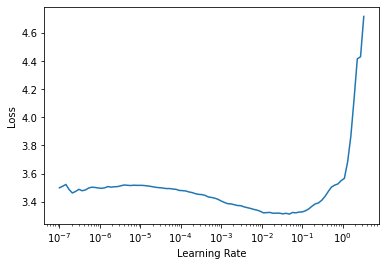

In [19]:
learner2.lr_find()

In [20]:
learner2.fit_one_cycle(31,1e-4, div=0.9, final_div=10000, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,3.078480,2.917600,0.214615,00:26
1,2.892562,2.781298,0.241154,00:26
2,2.774430,2.634692,0.274231,00:26
3,2.671543,2.587525,0.286154,00:26
4,2.571240,2.544512,0.306154,00:26
5,2.514565,2.445433,0.312692,00:26
6,2.474993,2.407787,0.331154,00:26
7,2.424381,2.362143,0.342692,00:26
8,2.388049,2.349093,0.340769,00:26
9,2.350883,2.298494,0.361154,00:26


> **Entrenamos ahora con el dataset de flores**

**Cambiamos el tamaño de la última capa para poder entrenar con flowers y no obtener error por las categorias**

In [21]:
my_aux_model[-1] = nn.Linear(256, data_flowers.c)

In [22]:
learner3 = fv.Learner(data_flowers, my_aux_model, opt_func=fv.ranger, metrics=fv.accuracy, splitter=my_own_splitter).to_fp16()

SuggestedLRs(lr_min=0.010000000149011612, lr_steep=0.001737800776027143)

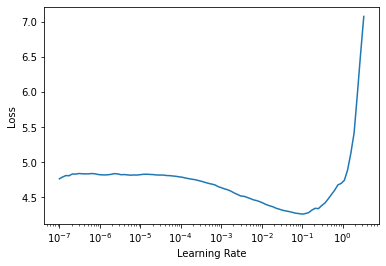

In [23]:
learner3.lr_find()

In [24]:
learner3.fit_one_cycle(31,1e-4, div=0.9, final_div=10000, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,3.943899,3.631820,0.229249,00:20
1,3.388336,3.159088,0.296443,00:20
2,3.042006,2.862248,0.371542,00:20
3,2.761327,2.601143,0.385375,00:20
4,2.556658,2.405721,0.424901,00:20
5,2.373017,2.261703,0.482213,00:20
6,2.209390,2.092956,0.498024,00:20
7,2.084204,1.935031,0.551383,00:20
8,1.975149,1.883290,0.569170,00:20
9,1.849403,1.840193,0.586957,00:20


<a id="comparacion"><h1><strong> 4. Después, re-entrena SOLO las últimas capas en tu dataset original, y compara: ¿fue mejor pre-entrenar con otros datos, o no sirvió de nada?</strong></h1></a>

> **Congelamos entonces todas las capas, exceptuando la última**

In [25]:
learner4 = fv.Learner(data_birds, my_aux_model, opt_func=fv.ranger, metrics=fv.accuracy, splitter=my_own_splitter).to_fp16()

In [26]:
learner4.freeze_to(-1) # congela todas excepto la última
# NOTA: Las batchnorm nunca las congela

> **modificamos la última capa pero ahora con las categorias del dataset original (birds) para entrenarla**

In [27]:
my_aux_model[-1] = nn.Linear(256, data_birds.c)

SuggestedLRs(lr_min=0.2754228591918945, lr_steep=0.019054606556892395)

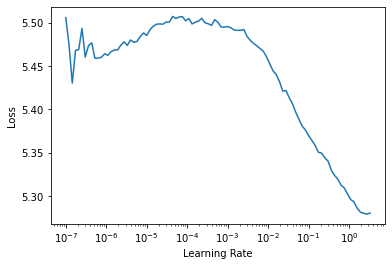

In [28]:
learner4.lr_find()

> Notese que para el cuarto aprendedor, la gráfica del learning rate ya cuenta con una pendiente más pronunciada. Tal vez debido a que el modelo ya fue previamente entrenado con otros datos antes de birds.

In [29]:
#Empleamos los parámetros aprendidos con los vídeos para ver si hay mejoras considerables
learner4.fit_one_cycle(31,1e-4, div=0.9, final_div=10000, pct_start=0.8)
#learn.fit_One_cycle(10,1e-3, div = algoalrededor de 1, final_div=algomuygrande,pct_start=0.7,8,9)

epoch,train_loss,valid_loss,accuracy,time
0,5.434218,5.386080,0.009147,00:16
1,5.315916,5.282404,0.013117,00:16
2,5.204808,5.202667,0.015878,00:16
3,5.119037,5.151608,0.019503,00:16
4,5.047928,5.107184,0.022782,00:16
5,4.995423,5.071865,0.025198,00:16
6,4.948391,5.039261,0.030721,00:16
7,4.919967,5.014663,0.031067,00:16
8,4.886099,4.995422,0.034518,00:16
9,4.865083,4.979232,0.036590,00:16


> **Observamos la gran diferencia en cuanto al accuracy respecto al primer modelo. 
Es decir, si entrenamos primero con otros datos, antes de entrenar con los nuestros obtenemos una tercera parte de accuracy respecto a cuando entrenamos el modelo únicamente con nuestros datos. Pero tal vez se debe a que entrenamos únicamente las últimas capas es decir la que se encarga de darnos la categoria.**

**dandole continuidad y para ver si mejora (porqué ya me dio curiosidad), procedemos a descongelar las capas y entrenar nuevamente con los datos originales pero ahora todas las capas con la finalidad de ver si hay mejoras**.

## Entrenamiento de todas las capas

In [30]:
learner4.unfreeze()

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=5.248074739938602e-05)

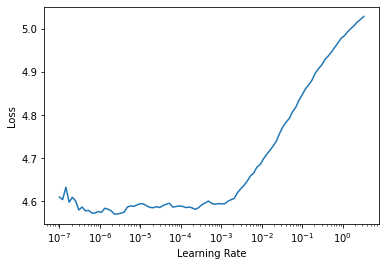

In [31]:
learner4.lr_find()

In [32]:
learner4.fit_one_cycle(41,1e-4, div=0.9, final_div=10000, pct_start=0.8)

epoch,train_loss,valid_loss,accuracy,time
0,4.602699,4.795527,0.061443,00:18
1,4.570249,4.755149,0.068174,00:18
2,4.538473,4.723031,0.067138,00:18
3,4.501624,4.691550,0.073007,00:18
4,4.455942,4.659834,0.073870,00:18
5,4.428517,4.637400,0.083880,00:18
6,4.394197,4.602984,0.084398,00:18
7,4.342920,4.597621,0.085433,00:18
8,4.315875,4.555669,0.085951,00:18
9,4.276310,4.544923,0.100621,00:18


> **Ahora que hemos descongelado todas las capas y entrenado con nuestros datos de pajaritos (recordemos que primero entrenamos con datos de animales y flores), observamos que hubo una mejora considerable respecto a entrenar el modelo únicamente con pajaritos, teniendo un accuracy mayor por 0.03. Pero observemos que en este caso entrenamos 40 epocas, y en el primer modelo fueron 30. Por lo que si comparamos el accuracy de este modelo en la epoca 30 respecto al primer modelo, tenemos solo que es mayor por 0.01**

In [33]:
learner4.save('stage1_learner4') #Guardamos el modelo como va de entrenado hasta ahora

Path('models/stage1_learner4.pth')

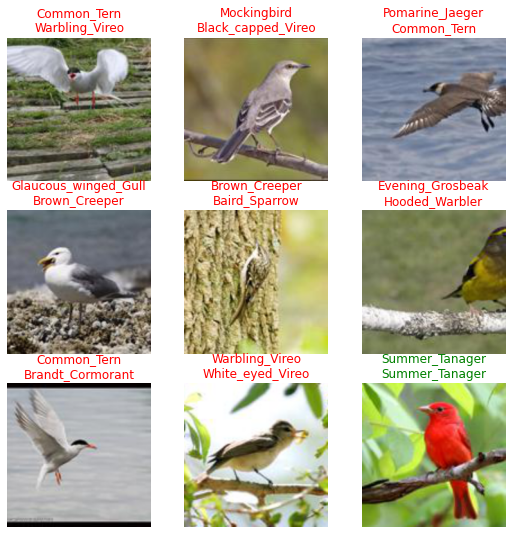

In [34]:
learner4.show_results()

<a id="mytfms"><h1><strong> 5. Crea una Transform que se aplique aleatoriamente con probabilidad 1/10 que convierta a la imagen en blanco y negro (escala de grises).</strong></h1></a>

> Para crear nuestra transformación nos vamos a basar en esta documentación: [Tutorial - Custom transforms](https://docs.fast.ai/tutorial.albumentations) de fastai

In [7]:
from fastai.vision.all import *
from PIL import Image
import numpy as np
from albumentations import ShiftScaleRotate




img = Image.open("/storage/recursos/birds/valid/Acadian_Flycatcher/Acadian_Flycatcher_0005_29157.jpg")

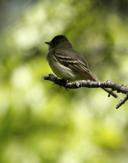

In [58]:
img

In [86]:
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor()
to_pil = ToPILImage()

def tf_gray(img):
    """
        Dado que se pasa una a una las imagenes a mi transformada
        Lo que haremos para determinar si se aplica o no la transformada
        Con probabilidad 1/10 será asígnar un número a esa imagen que 
        Justamente corresponde a su probabilidad, de esta manera
        Nos limitamos a aplicar o no la transformada a una sola imagen 
        En todo el batch. Hemos de asignar dos parámetros a nuestra función.
    """
    # Para hacer la transformada   
    # Tomamos las capas de colores de la imagen 
    # i[0] = red; i[1] = green; i[2] = blue
    # y las multiplicamos por el estandar obtenido de:
    # https://pythoneyes.wordpress.com/2017/05/22/conversion-de-imagenes-rgb-a-escala-de-grises/
    #img_gray = [torch.stack([0.299*i[0]+0.587*i[1]+0.114*i[2]]*3) for i in img] # para todo el batch
    img_gray = [torch.stack([0.299*i[0]+0.587*i[1]+0.114*i[2]]*3) if (random.randrange(11) == 0) else i for i in img]
    img_gray = torch.stack(img_gray)
    img_gray = fv.TensorImage(img_gray)
        
    return (img_gray)
    

In [87]:
class MyTransform(fv.Transform):
    def __init__(self, tf_gray):
        self.tf_gray = tf_gray
        
    def encodes(self, img: fv.TensorImage):
       
        gray_img = self.tf_gray(img)
        return (gray_img)

In [88]:
# Función para cargar los datos
def load_data_aux(folder, img_size, batch_size):
  # Dependiendo de los datos, elegimos las 
  # transformadas que le queremos hacer
  tfms = fv.aug_transforms(flip_vert=True, 
                           max_rotate=360, 
                           max_lighting=0.25,
                           max_zoom=1.2, 
                           max_warp=0.2,
                           xtra_tfms=MyTransform(tf_gray)
                          )
  
  data = fv.DataBlock(blocks = (fv.ImageBlock, fv.CategoryBlock),
                      get_items=fv.get_image_files,
                      get_y=fv.parent_label,
                      splitter=fv.GrandparentSplitter(), 
                      item_tfms=fv.Resize(img_size),
                      batch_tfms=tfms,
                      )
  return data.dataloaders(folder, bs=batch_size)

In [101]:
data_birds_aux = load_data_aux(birds, img_size=224, batch_size=24)

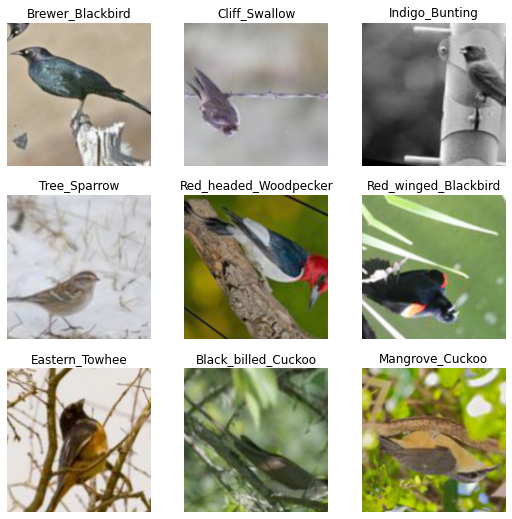

In [102]:
data_birds_aux.show_batch()

**Esto no importa, fueron las pruebas que estuve haciendo para que este show funcionara**
Que a grandes rasgos consistio en leer la documentación sobre DataBlock y las transformaciones para poder 
ver donde se podia iterar para obtener una única imagen para decidir si aplicarle la transformada o no. 

In [104]:
from torchvision.transforms import ToTensor, ToPILImage
to_tensor = ToTensor()
to_pil = ToPILImage()



def tf_gray_extra(img):
    print("ENTRE!!!!")
    # dado que solo debe de aplicarse 1/10 veces
    # hacemos uso de random
    # Tomamos las capas de colores de la imagen 
    # i[0] = red; i[1] = green; i[2] = blue
    # y las multiplicamos por el estandar obtenido de:
    # https://pythoneyes.wordpress.com/2017/05/22/conversion-de-imagenes-rgb-a-escala-de-grises/
    
    #FUNCIONAL PARA TODO EL BATCH
    #img_gray = [torch.stack([0.299*i[0]+0.587*i[1]+0.114*i[2]]*3) for i in img]
    
    #Para una sola imagen. Randrange incluye al 0 y no al 10, de ahí que tomemos == 0 
    img_gray = [torch.stack([0.299*i[0]+0.587*i[1]+0.114*i[2]]*3) if (random.randrange(10) == 0) else i for i in img]
    img_gray = torch.stack(img_gray)
    img_gray = fv.TensorImage(img_gray)
        
    return (img_gray)

In [59]:
class MyTransformExtra(fv.Transform):
    def __init__(self, tf_gray_extra):
        self.tf_gray_extra = tf_gray_extra
        
    def encodes(self, img: fv.TensorImage):
       
        gray_img = self.tf_gray_extra(img)
        return (gray_img)
        

In [103]:
# Función para cargar los datos
def load_data_aux_extra(folder, img_size, batch_size):
  # Dependiendo de los datos, elegimos las 
  # transformadas que le queremos hacer
  # No ES ITERABLE 
  tfms = fv.aug_transforms(flip_vert=True, 
                           max_rotate=360, 
                           max_lighting=0.25,
                           max_zoom=1.2, 
                           max_warp=0.2,
                           xtra_tfms=MyTransformExtra(tf_gray_extra)
                          )

  # PARAMETROS NO ITERABLES
  data = fv.DataBlock(blocks = (fv.ImageBlock, fv.CategoryBlock),
                      get_items=fv.get_image_files,
                      get_y=fv.parent_label,
                      splitter=fv.GrandparentSplitter(), 
                      item_tfms=fv.Resize(img_size),
                      batch_tfms=tfms,
                      )
  return data.dataloaders(folder, bs=batch_size)

ENTRE!!!!
ENTRE!!!!


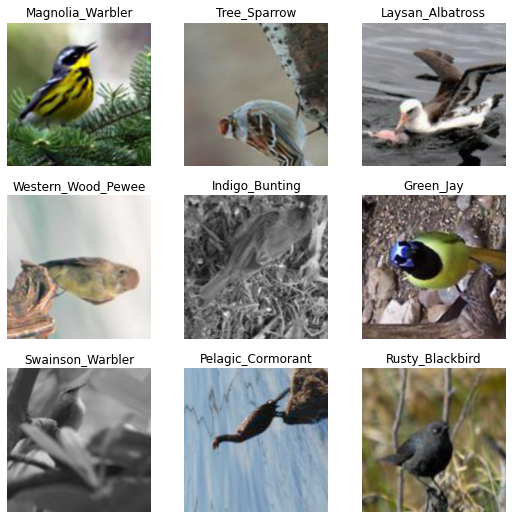

In [62]:
birds_aux = load_data_aux_extra(birds, img_size=224, batch_size=9)
birds_aux.show_batch()

In [34]:
import random 
torch.rand(random.randrange(10))

tensor([0.0641, 0.8619, 0.5862, 0.0156, 0.8880, 0.2528, 0.5812, 0.0306])

In [17]:
torch.rand(1)

tensor([0.6973])

In [83]:
torch.arange(random.uniform(0, 10))

tensor([0., 1., 2., 3., 4.])

In [36]:
random.randrange(10)

1

In [100]:
tmp = []
for x in range(0,101,1):
    tmp2 = random.randrange(10)
    if tmp2 == 0:
        tmp.append(x)
print(tmp)

[21, 27, 37, 62, 75, 88, 90]


In [82]:
tmp = []
for x in range(0,101,1):
    tmp2 = random.uniform(0, 10)
    #print(tmp)
    if tmp2 <= 1.0:
        tmp.append(x)
print(tmp)

[1, 4, 12, 26, 32, 42, 51, 52, 56, 67, 77, 82, 88, 93, 98]
